In [6]:
# Import libraries
import sys

import networkx as nx
import pandas as pd
import numpy as np
import os

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN

import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import json

In [2]:
# Setup GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [76]:
# Autoreloads modules that have changed like metrics.py
%load_ext autoreload
%autoreload 2


Test metrics:
Accuracy: 0.6667
Precision macro: 0.5000
Recall macro: 0.6667
F1 Score macro: 0.5556


c:\Users\zhzj\anaconda3\envs\rse-preliminary-analysis\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


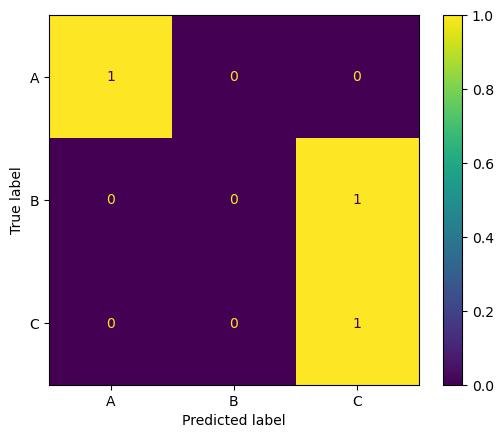

In [77]:
import diy_metrics
from diy_metrics import *
diy_metrics.example()

## Load Data and Preprocessing

In [7]:
# Import dataset
G = nx.read_graphml( "../data/cora/cora.graphml" )

print(G) # should print a graph with 2708 nodes and 5429 edges (directed) 

# in this case, we have created a undirected graph, so the numbers of edges are diffent from the original paper

Graph with 2708 nodes and 5278 edges


In [4]:
G.graph

{'node_default': {}, 'edge_default': {}}

In [63]:
labels = nx.get_node_attributes(G, "subject")
labels = set(labels.values())
print( labels ) # should print 7 different labels

{'Neural_Networks', 'Genetic_Algorithms', 'Rule_Learning', 'Probabilistic_Methods', 'Case_Based', 'Reinforcement_Learning', 'Theory'}


In [3]:
# fast check: counter nodes per class
node_subjects = pd.Series( [ G.nodes[node]['subject'] for node in G.nodes() ], index = G.nodes() )
node_subjects.value_counts() # -> wrong, should be 20 nodes per class

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
dtype: int64

In [3]:
# fast check: extract first 140 nodes and counter on their label

node_subjects = pd.Series( [ G.nodes[node]['subject'] for node in G.nodes() ], index = G.nodes() )
node_subjects.head(140).value_counts() # -> wrong, should be 20 nodes per class

Genetic_Algorithms        129
Neural_Networks             5
Reinforcement_Learning      3
Theory                      2
Case_Based                  1
dtype: int64

In [5]:
f = open("../ind.cora.test.index", "r")
test_idx = pd.read_csv(f, header=None)

# compare test_idx with node_subjects(last 1000 nodes)
myList = node_subjects.tail(1000).index.tolist()

# check if test_idx is a subset of myList
test_idx == myList

ValueError: Unable to coerce to Series, length must be 1: given 1000

In [5]:
print( json.dumps( list( G.nodes(data=True) )[0], indent = 4 ) ) # 1-1432: weights, 1433: subject

[
    "1033",
    {
        "label": "paper",
        "w_0": 0,
        "w_1": 0,
        "w_2": 0,
        "w_3": 0,
        "w_4": 0,
        "w_5": 0,
        "w_6": 0,
        "w_7": 0,
        "w_8": 0,
        "w_9": 1,
        "w_10": 0,
        "w_11": 0,
        "w_12": 0,
        "w_13": 0,
        "w_14": 0,
        "w_15": 0,
        "w_16": 0,
        "w_17": 0,
        "w_18": 0,
        "w_19": 0,
        "w_20": 0,
        "w_21": 0,
        "w_22": 0,
        "w_23": 0,
        "w_24": 0,
        "w_25": 0,
        "w_26": 0,
        "w_27": 0,
        "w_28": 0,
        "w_29": 0,
        "w_30": 0,
        "w_31": 0,
        "w_32": 0,
        "w_33": 0,
        "w_34": 0,
        "w_35": 0,
        "w_36": 0,
        "w_37": 0,
        "w_38": 0,
        "w_39": 0,
        "w_40": 0,
        "w_41": 0,
        "w_42": 0,
        "w_43": 0,
        "w_44": 0,
        "w_45": 0,
        "w_46": 0,
        "w_47": 0,
        "w_48": 0,
        "w_49": 0,
        "w_50"

In [6]:
for node in G.nodes():
    print( G.nodes[node]['subject'] )
    break

Genetic_Algorithms


In [8]:
# for each node, encode weight as a feature
for node in G.nodes():
    enc = [ val for key, val in G.nodes[node].items() if key != 'subject' and key != 'label' ]
    G.nodes[node]['feature'] = enc

In [8]:
for node in G.nodes( data=True ):
    print( node )
    break

('1033', {'label': 'paper', 'w_0': 0, 'w_1': 0, 'w_2': 0, 'w_3': 0, 'w_4': 0, 'w_5': 0, 'w_6': 0, 'w_7': 0, 'w_8': 0, 'w_9': 1, 'w_10': 0, 'w_11': 0, 'w_12': 0, 'w_13': 0, 'w_14': 0, 'w_15': 0, 'w_16': 0, 'w_17': 0, 'w_18': 0, 'w_19': 0, 'w_20': 0, 'w_21': 0, 'w_22': 0, 'w_23': 0, 'w_24': 0, 'w_25': 0, 'w_26': 0, 'w_27': 0, 'w_28': 0, 'w_29': 0, 'w_30': 0, 'w_31': 0, 'w_32': 0, 'w_33': 0, 'w_34': 0, 'w_35': 0, 'w_36': 0, 'w_37': 0, 'w_38': 0, 'w_39': 0, 'w_40': 0, 'w_41': 0, 'w_42': 0, 'w_43': 0, 'w_44': 0, 'w_45': 0, 'w_46': 0, 'w_47': 0, 'w_48': 0, 'w_49': 0, 'w_50': 0, 'w_51': 0, 'w_52': 0, 'w_53': 0, 'w_54': 0, 'w_55': 0, 'w_56': 0, 'w_57': 0, 'w_58': 0, 'w_59': 0, 'w_60': 0, 'w_61': 0, 'w_62': 0, 'w_63': 0, 'w_64': 0, 'w_65': 0, 'w_66': 0, 'w_67': 0, 'w_68': 0, 'w_69': 0, 'w_70': 0, 'w_71': 0, 'w_72': 0, 'w_73': 0, 'w_74': 0, 'w_75': 0, 'w_76': 0, 'w_77': 0, 'w_78': 0, 'w_79': 0, 'w_80': 0, 'w_81': 0, 'w_82': 0, 'w_83': 0, 'w_84': 0, 'w_85': 0, 'w_86': 0, 'w_87': 0, 'w_88': 0, 'w_

In [9]:
# copy graph
from copy import deepcopy
G2 = deepcopy(G)

# remove redundant weight attributes from nodes
for node in G2.nodes():
    for key in G2.nodes[node].keys():
        if key != 'subject' and key != 'label' and key != 'feature':
            G.nodes[node].pop(key)

del G2

In [10]:
# print node attributes
for node in G.nodes( data=True ):
    print( node )
    break

('1033', {'label': 'paper', 'subject': 'Genetic_Algorithms', 'feature': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [11]:
print( json.dumps( list( G.nodes(data=True) )[0], indent = 4 ) )

[
    "1033",
    {
        "label": "paper",
        "subject": "Genetic_Algorithms",
        "feature": [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
       

In [12]:
print( json.dumps( list( G.edges(data=True) )[0], indent = 4 ) )

[
    "1033",
    "35",
    {
        "label": "cites"
    }
]


## Create StellarGraph

In [10]:
SG = StellarGraph.from_networkx(
    graph=G, node_type_default="subject", node_features="feature"
)

print( SG.info() )

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]
        Weights: all 1 (default)
        Features: none


In [11]:
# create a node_subjects Pandas Series with node IDs as index and subject as value
node_subjects = pd.Series( [ G.nodes[node]['subject'] for node in G.nodes() ], index = G.nodes() )
print( node_subjects.head() )

1033       Genetic_Algorithms
35         Genetic_Algorithms
103482        Neural_Networks
103515     Genetic_Algorithms
1050679    Genetic_Algorithms
dtype: object


In [12]:
# split into train and test sets
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.7, test_size=None, stratify=node_subjects
)

print( train_subjects )

1116181                Theory
4878               Case_Based
444240     Genetic_Algorithms
59244              Case_Based
50354         Neural_Networks
                  ...        
25805                  Theory
824245        Neural_Networks
1110390            Case_Based
23116                  Theory
1129629    Genetic_Algorithms
Length: 1895, dtype: object


In [13]:
from collections import Counter
Counter(train_subjects) # consider imbalance between class

Counter({'Theory': 246,
         'Case_Based': 209,
         'Genetic_Algorithms': 292,
         'Neural_Networks': 572,
         'Probabilistic_Methods': 298,
         'Reinforcement_Learning': 152,
         'Rule_Learning': 126})

In [14]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
test_targets = le.transform(test_subjects)

In [18]:
print( train_targets ) # for each node, the subject is encoded as a number

[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


## Define benchmarking metrics

In [19]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score

# THIS CODE NEEDS TO BE FIXED

def benchmarking_result( targets, predictions ) :
    # Accuracy
    train_acc = np.mean( targets == predictions )

    # Confusion matrix
    # cm = confusion_matrix( targets, predictions )

    # Precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support( targets, predictions, average='micro' )

    # AUC-ROC
    # auc = roc_auc_score( targets, predictions )

    return train_acc, precision, recall, f1


## GraphSAGE model

In [90]:
batch_size = 50
num_samples = [10, 10]

generator = GraphSAGENodeGenerator( SG, batch_size, num_samples )

In [91]:
train_gen = generator.flow( train_subjects.index, train_targets, shuffle = True )

In [92]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5
)

In [93]:
print( train_targets.shape )

(140, 7)


In [94]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Train model

In [95]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [96]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 10, 1433)]   0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 100, 1433)]  0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 1, 1433)]    0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 10, 1433)  0           ['input_10[0][0]']               
                                                                                            

In [26]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [27]:
history = model.fit(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

### Benchmark model

In [ ]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

In [ ]:
node_predictions = le.inverse_transform(all_predictions)

In [ ]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(10)

In [ ]:
# calculate accuracy
df['Correct'] = df['Predicted'] == df['True']
df['Correct'].value_counts()

In [ ]:
accuracy = df['Correct'].value_counts()[True] / df['Correct'].value_counts().sum()
print( accuracy )

## GCN model

In [37]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects, random_state=42
)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [38]:
train_subjects.value_counts().to_frame() # why is equal to demo?

,0
Neural_Networks,42
Probabilistic_Methods,22
Genetic_Algorithms,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


In [39]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
val_targets = le.transform(val_subjects)
test_targets = le.transform(test_subjects)

In [40]:
generator = FullBatchNodeGenerator(SG, method="gcn")

Using GCN (local pooling) filters...


In [41]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [42]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [43]:
x_inp, x_out = gcn.in_out_tensors()
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Train model

In [44]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [45]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(1, 2708, 1433)]    0           []                               
                                                                                                  
 input_7 (InputLayer)           [(1, None, 2)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(1, None)]          0           []                               
                                                                                                  
 dropout_2 (Dropout)            (1, 2708, 1433)      0           ['input_5[0][0]']                
                                                                                            

In [46]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [47]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [48]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 2s - loss: 1.9468 - acc: 0.1500 - val_loss: 1.9353 - val_acc: 0.2720 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.9259 - acc: 0.2786 - val_loss: 1.9237 - val_acc: 0.4160 - 206ms/epoch - 206ms/step
Epoch 3/200
1/1 - 0s - loss: 1.9064 - acc: 0.3929 - val_loss: 1.9068 - val_acc: 0.4840 - 198ms/epoch - 198ms/step
Epoch 4/200
1/1 - 0s - loss: 1.8945 - acc: 0.4286 - val_loss: 1.8853 - val_acc: 0.5240 - 191ms/epoch - 191ms/step
Epoch 5/200
1/1 - 0s - loss: 1.8577 - acc: 0.4357 - val_loss: 1.8596 - val_acc: 0.5240 - 171ms/epoch - 171ms/step
Epoch 6/200
1/1 - 0s - loss: 1.8197 - acc: 0.5357 - val_loss: 1.8300 - val_acc: 0.5320 - 185ms/epoch - 185ms/step
Epoch 7/200
1/1 - 0s - loss: 1.7689 - acc: 0.5286 - val_loss: 1.7970 - val_acc: 0.5360 - 169ms/epoch - 169ms/step
Epoch 8/200
1/1 - 0s - loss: 1.7432 - acc: 0.5857 - val_loss: 1.7615 - val_acc: 0.5380 - 171ms/epoch - 171ms/step
Epoch 9/200
1/1 - 0s - loss: 1.7010 - acc: 0.5357 - val_loss: 1.7231 - val_acc: 0.5380 - 363ms

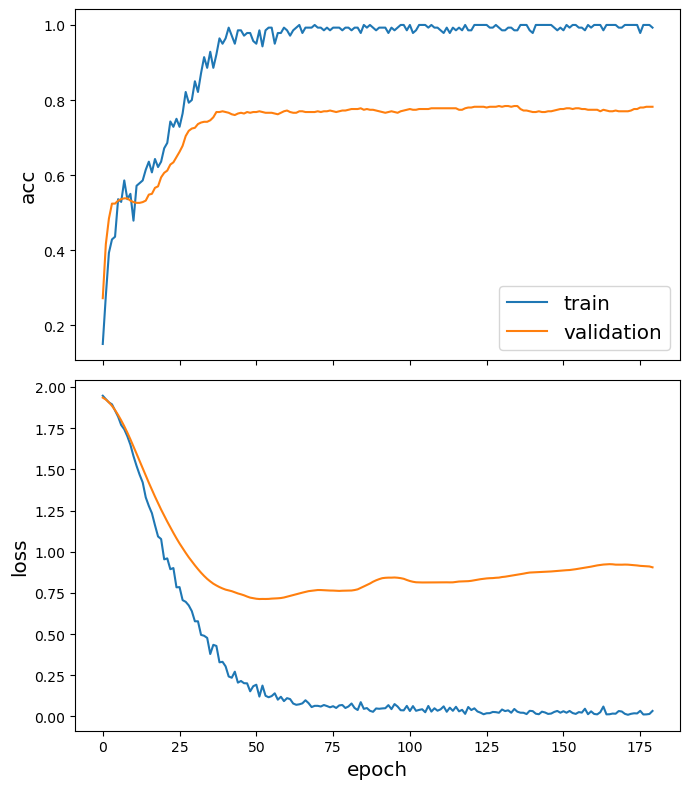

In [49]:
sg.utils.plot_history(history)

In [50]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [51]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 92ms/step - loss: 0.7732 - acc: 0.8075

Test Set Metrics:
	loss: 0.7732
	acc: 0.8075


### Benchmark model

In [52]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

node_predictions = le.inverse_transform(all_predictions.squeeze())


1/1 [==============================] - 0s 310ms/step


In [53]:

df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(10)


,Predicted,True
1033,Genetic_Algorithms,Genetic_Algorithms
35,Genetic_Algorithms,Genetic_Algorithms
103482,Genetic_Algorithms,Neural_Networks
103515,Genetic_Algorithms,Genetic_Algorithms
1050679,Genetic_Algorithms,Genetic_Algorithms
1103960,Genetic_Algorithms,Genetic_Algorithms
1103985,Genetic_Algorithms,Genetic_Algorithms
1109199,Genetic_Algorithms,Genetic_Algorithms
1112911,Genetic_Algorithms,Genetic_Algorithms
1113438,Genetic_Algorithms,Genetic_Algorithms


In [54]:
# calculate accuracy
df['Correct'] = df['Predicted'] == df['True']
df['Correct'].value_counts()

True     2202
False     506
Name: Correct, dtype: int64

In [56]:
accuracy = df['Correct'].value_counts()[True] / df['Correct'].value_counts().sum()
print( accuracy )

0.8131462333825702


In [72]:
predictions = np.argmax(all_predictions, axis=0)
predictions.shape

(2708, 7)

In [68]:
y_true.shape

(2708, 7)

c:\Users\zhzj\anaconda3\envs\rse-preliminary-analysis\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test metrics:
Accuracy: 0.1100
Precision macro: 0.0157
Recall macro: 0.1429
F1 Score macro: 0.0283
AUC-ROC macro,ovr: 0.5000


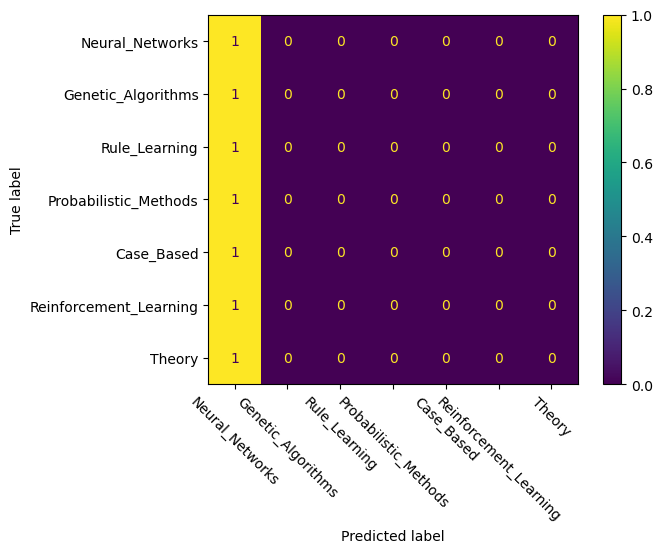

In [100]:
# Visualize diy_metrics

# One-Hot Encoding for node_subjects
y_true = pd.get_dummies(node_subjects.values).values

diy_metrics.display_and_save( Framework.STELLARGRAPH, Datasets.CORA, "GCN", 
                            predictions, y_true, labels, exec_ms = 1000 )

## GAT model

In [ ]:
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

In [ ]:
# split data
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects, random_state=42
)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [ ]:
from collections import Counter

Counter(train_subjects)

In [ ]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
val_targets = le.transform(val_subjects)
test_targets = le.transform(test_subjects)

In [ ]:
# Create the GAT model
generator = FullBatchNodeGenerator(SG, method="gat")

In [ ]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [ ]:
gat = GAT(
    layer_sizes=[16, 16],
    activations=["elu", "elu"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

In [ ]:
x_inp, x_out = gat.in_out_tensors()
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [ ]:
model = Model(inputs=x_inp, outputs= predictions)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
model.summary()

In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [ ]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

In [ ]:
sg.utils.plot_history(history)

In [ ]:
model.load_weights("logs/best_model.h5")

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))